# Feature Overview

This notebook provides a simple overview of the basic functionality of PySINDy. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.4.3?filepath=examples/1_feature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

## Basic usage
We will fit a SINDy model to the famous Lorenz system:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$


### Train the model

In [3]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train).y.T

In [4]:
# Instantiate and fit the SINDy model
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Assess results on a test trajectory

In [5]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test).y.T  

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.999924


### Predict derivatives with learned model

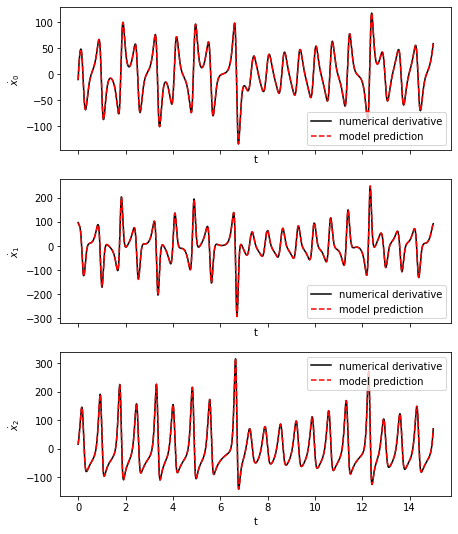

In [6]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time

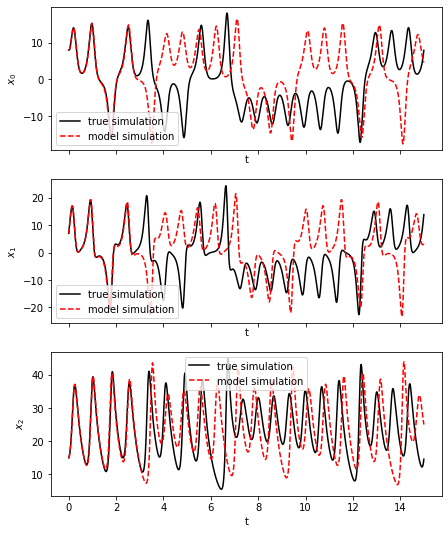

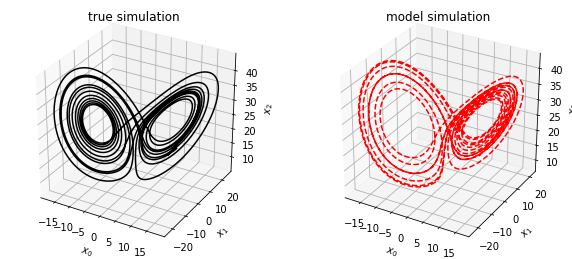

In [7]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

## Different forms of input data

Here we explore different types of input data accepted by the the `SINDy` class.

### Single trajectory, pass in collection times

In [8]:
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Single trajectory, set default timestep
Since we used a uniform timestep when defining `t_train` we can tell set a default timestep to be used whenever `t` isn't passed in.

In [9]:
model = ps.SINDy(t_default=dt)
model.fit(x_train)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Single trajectory, pass in pre-computed derivatives

In [10]:
x_dot_true = np.zeros(x_train.shape)
for i in range(t_train.size):
    x_dot_true[i] = lorenz(t_train[i], x_train[i])
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_true)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [11]:
model = ps.SINDy()

### Multiple trajectories
We use the Lorenz equations to evolve multiple different initial conditions forward in time, passing all the trajectories into a single `SINDy` object. Note that `x_train_multi` is a list of 2D numpy arrays.

In [12]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(solve_ivp(lorenz, t_train_span, x0s[i], t_eval=t_train).y.T)

model = ps.SINDy()
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.820 x0 + -0.967 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Multiple trajectories, different lengths of time
This example is similar to the previous one, but each trajectory consists of a different number of measurements.

In [13]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500, 1500)
    t = np.arange(0, n_samples * dt, dt)
    t_span = (t[0], t[-1])
    x_train_multi.append(solve_ivp(lorenz, t_span, x0s[i], t_eval=t).y.T)
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()

(x0)' = -10.003 x0 + 10.003 x1
(x1)' = 27.884 x0 + -0.984 x1 + -0.996 x0 x2
(x2)' = -2.667 x2 + 0.999 x0 x1


### Discrete time dynamical system (map)

In [14]:
def f(x):
    return 3.6 * x * (1 - x)


n_steps = 1000
eps = 0.001  # Noise level
x_train_map = np.zeros((n_steps))
x_train_map[0] = 0.5
for i in range(1, n_steps):
    x_train_map[i] = f(x_train_map[i - 1]) + eps * np.random.randn()

model = ps.SINDy(discrete_time=True)
model.fit(x_train_map)
model.print()

(x0)[k+1] = 3.600 x0[k] + -3.600 x0[k]^2


### Pandas DataFrame

In [15]:
import pandas as pd

# Create a dataframe with entries corresponding to measurements and
# indexed by the time at which the measurements were taken
df = pd.DataFrame(data=x_train, columns=['x', 'y', 'z'], index=t_train)

# The column names can be used as feature names
model = ps.SINDy(feature_names=df.columns)

# Everything needs to be converted to numpy arrays to be passed in
model.fit(df.values, t=df.index.values)
model.print()

(x)' = -10.004 x + 10.004 y
(y)' = 27.822 x + -0.968 y + -0.994 x z
(z)' = -2.666 z + 0.999 x y


## Optimization options
In this section we provide examples of different parameters accepted by the built-in sparse regression optimizers `STLSQ`, `SR3`, `ConstrainedSR3`, `SSR`, and `FROLS`. The `Trapping` optimizer is not straightforward to use; please check out Example 8 for some examples. We also show how to use a scikit-learn sparse regressor with PySINDy.

### STLSQ - change parameters

In [16]:
stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.5)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -0.057 1 + -0.015 x0 + 0.012 x1 + -2.663 x2 + 0.999 x0 x1


### SR3

In [17]:
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

model = ps.SINDy(optimizer=sr3_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = -0.010 1 + 27.824 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -0.057 1 + -0.015 x0 + 0.012 x1 + -2.663 x2 + 0.999 x0 x1


### SR3 - with trimming
`SR3` is capable of automatically trimming outliers from training data. Specifying the parameter `trimming_fraction` tells the method what fraction of samples should be trimmed.

In [18]:
corrupted_inds = np.random.randint(0, len(x_train), size=len(x_train) // 30)
x_train_corrupted = x_train.copy()
x_train_corrupted[corrupted_inds] += np.random.standard_normal((len(corrupted_inds), 3))

# Without trimming
sr3_optimizer = ps.SR3()
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("Without trimming")
model.print()

# With trimming
sr3_optimizer = ps.SR3(trimming_fraction=0.1)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("\nWith trimming")
model.print()

Without trimming
(x0)' = 0.184 1 + -9.945 x0 + 9.945 x1 + -0.008 x2
(x1)' = 0.005 1 + 27.663 x0 + -0.929 x1 + -0.990 x0 x2
(x2)' = -0.295 1 + -0.013 x0 + 0.016 x1 + -2.652 x2 + 0.999 x0 x1

With trimming
(x0)' = -9.949 x0 + 9.948 x1
(x1)' = 0.005 1 + 27.663 x0 + -0.929 x1 + -0.990 x0 x2
(x2)' = -0.264 1 + -2.653 x2 + 0.999 x0 x1


### SR3 regularizers 
The default regularizer with SR3 is the L0 norm, but L1 and L2 are allowed. Note that the pure L2 option is notably less sparse than the other options.

In [19]:
sr3_optimizer = ps.SR3(threshold=0.1)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("L0 regularizer: ")
model.print()

sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l1")
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("L1 regularizer: ")
model.print()

sr3_optimizer = ps.SR3(threshold=100, thresholder="l2")
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("L2 regularizer: ")
model.print()

L0 regularizer: 
(x0)' = 0.184 1 + -9.945 x0 + 9.945 x1 + -0.008 x2
(x1)' = 0.005 1 + 27.663 x0 + -0.929 x1 + -0.990 x0 x2
(x2)' = -0.295 1 + -0.013 x0 + 0.016 x1 + -2.652 x2 + 0.999 x0 x1
L1 regularizer: 
(x0)' = 0.184 1 + -9.945 x0 + 9.945 x1 + -0.008 x2
(x1)' = 0.005 1 + 27.663 x0 + -0.929 x1 + -0.990 x0 x2
(x2)' = -0.295 1 + -0.013 x0 + 0.016 x1 + -2.652 x2 + 0.999 x0 x1
L2 regularizer: 
(x0)' = -4.184 1 + -9.180 x0 + 9.477 x1 + 0.557 x2 + 0.084 x0^2 + -0.068 x0 x1 + -0.021 x0 x2 + 0.010 x1^2 + 0.012 x1 x2 + -0.017 x2^2
(x1)' = 0.477 1 + 27.228 x0 + -0.624 x1 + -0.074 x2 + -0.020 x0^2 + 0.025 x0 x1 + -0.978 x0 x2 + -0.009 x1^2 + -0.009 x1 x2 + 0.003 x2^2
(x2)' = -0.293 1 + 0.339 x0 + -0.219 x1 + -2.653 x2 + 0.001 x0^2 + 0.997 x0 x1 + -0.010 x0 x2 + 0.007 x1 x2


/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:324: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  ConvergenceWarning,


### SR3 - with variable thresholding
`SR3` and its variants (ConstrainedSR3, TrappingSR3, SINDyPI) can use a matrix of thresholds to set different thresholds for different terms.

In [20]:
# Without thresholds matrix
sr3_optimizer = ps.SR3(threshold=0.1)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("Threshold = 0.1 for all terms")
model.print()

# With thresholds matrix
thresholds = np.ones((10, 3))
thresholds[4:, :] = 0.1
sr3_optimizer = ps.SR3(thresholder="weighted_l0", thresholds=thresholds)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt)
print("Threshold = 1 for non-quadratic terms, else threshold = 0.1")
model.print()

Threshold = 0.1 for all terms
(x0)' = 0.184 1 + -9.945 x0 + 9.945 x1 + -0.008 x2
(x1)' = 0.005 1 + 27.663 x0 + -0.929 x1 + -0.990 x0 x2
(x2)' = -0.295 1 + -0.013 x0 + 0.016 x1 + -2.652 x2 + 0.999 x0 x1
Threshold = 1 for non-quadratic terms, else threshold = 0.1
(x0)' = 0.011 1 + -9.949 x0 + 9.947 x1
(x1)' = 25.390 x0 + -0.945 x0 x2
(x2)' = -2.663 x2 + 0.999 x0 x1


### ConstrainedSR3
We can impose linear equality and inequality constraints on the coefficients in the `SINDy` model using the `ConstrainedSR3` class. Below we constrain the x0 coefficient in the second equation to be exactly 28 and the x0 and x1 coefficients in the first equations to be negatives of one another. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/7_plasma_examples.ipynb) for examples.

In [21]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit(x_train)
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (10): ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


In [22]:
# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()

(x0)' = -9.983 x0 + 9.983 x1
(x1)' = 0.351 1 + 28.000 x0 + -1.050 x1 + -0.998 x0 x2
(x2)' = -0.190 1 + 0.180 x0 + -0.111 x1 + -2.628 x2 + 0.990 x0 x1


In [23]:
# Try with normalize columns (doesn't work with constraints!)
optimizer = ps.ConstrainedSR3(normalize_columns=True, threshold=10)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()

(x0)' = -9.967 x0 + 9.976 x1 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = 0.601 1 + 27.563 x0 + -0.786 x1 + -0.069 x2 + -0.013 x0^2 + 0.016 x0 x1 + -0.986 x0 x2 + -0.006 x1^2 + -0.005 x1 x2 + 0.002 x2^2
(x2)' = -0.190 1 + 0.180 x0 + -0.111 x1 + -2.628 x2 + 0.012 x0^2 + 0.990 x0 x1 + -0.005 x0 x2 + 0.001 x1^2 + 0.004 x1 x2 + -0.002 x2^2


/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:380: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  ConvergenceWarning,


In [24]:
# Repeat with inequality constraints
eps = 1e-5
constraint_rhs = np.array([eps, -eps, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((3, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
constraint_lhs[1, 1] = -1
constraint_lhs[1, 2] = -1

# 1 * (x0 coefficient) <= 28
constraint_lhs[2, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,
    thresholder="l1",
    tol=1e-7,
)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()
print(optimizer.coef_[0, 1], optimizer.coef_[0, 2])

(x0)' = -0.062 1 + -9.983 x0 + 9.983 x1 + 0.006 x2 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = 0.600 1 + 27.563 x0 + -0.786 x1 + -0.069 x2 + -0.013 x0^2 + 0.016 x0 x1 + -0.986 x0 x2 + -0.006 x1^2 + -0.005 x1 x2 + 0.002 x2^2
(x2)' = -0.188 1 + 0.180 x0 + -0.111 x1 + -2.628 x2 + 0.012 x0^2 + 0.990 x0 x1 + -0.005 x0 x2 + 0.001 x1^2 + 0.004 x1 x2 + -0.002 x2^2
-9.982814916652629 9.982824916657803


### SSR (greedy algorithm)
Stepwise sparse regression (SSR) is a greedy algorithm which solves the problem (defaults to ridge regression) by iteratively truncating the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways, truncating the smallest coefficient at each iteration, or chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/11_SSR_FROLS.ipynb) for examples.

In [25]:
ssr_optimizer = ps.SSR(alpha=.05)

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.059 1 + -9.959 x0 + 9.971 x1 + 0.006 x2 + 0.001 x0^2 + -0.001 x0 x1 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = 0.601 1 + 27.563 x0 + -0.786 x1 + -0.069 x2 + -0.013 x0^2 + 0.016 x0 x1 + -0.986 x0 x2 + -0.006 x1^2 + -0.005 x1 x2 + 0.002 x2^2
(x2)' = -0.190 1 + 0.180 x0 + -0.111 x1 + -2.628 x2 + 0.012 x0^2 + 0.990 x0 x1 + -0.005 x0 x2 + 0.001 x1^2 + 0.004 x1 x2 + -0.002 x2^2


In [26]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.059 1 + -9.959 x0 + 9.971 x1 + 0.006 x2 + 0.001 x0^2 + -0.001 x0 x1 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = 0.601 1 + 27.563 x0 + -0.786 x1 + -0.069 x2 + -0.013 x0^2 + 0.016 x0 x1 + -0.986 x0 x2 + -0.006 x1^2 + -0.005 x1 x2 + 0.002 x2^2
(x2)' = -0.190 1 + 0.180 x0 + -0.111 x1 + -2.628 x2 + 0.012 x0^2 + 0.990 x0 x1 + -0.005 x0 x2 + 0.001 x1^2 + 0.004 x1 x2 + -0.002 x2^2


The kappa parameter determines how sparse a solution is desired.

In [27]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual", kappa=1e-3)
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.032 1 + -9.961 x0 + 9.972 x1 + 0.002 x2 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = 27.572 x0 + -0.797 x1 + -0.003 x2 + -0.007 x0^2 + 0.012 x0 x1 + -0.987 x0 x2 + -0.005 x1^2 + -0.005 x1 x2
(x2)' = 0.177 x0 + -0.108 x1 + -2.648 x2 + 0.010 x0^2 + 0.991 x0 x1 + -0.005 x0 x2 + 0.001 x1^2 + 0.003 x1 x2 + -0.001 x2^2


### FROLS (greedy algorithm)
Forward Regression Orthogonal Least Squares (FROLS) is another greedy algorithm which solves the least-squares regression problem (actually default is to solve ridge regression) with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/11_SSR_FROLS.ipynb) for examples.

In [28]:
optimizer = ps.FROLS(alpha=.05)
model = ps.SINDy(optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.011 1 + -9.960 x0 + 9.972 x1 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = 27.573 x0 + -0.797 x1 + -0.006 x0^2 + 0.012 x0 x1 + -0.987 x0 x2 + -0.005 x1^2 + -0.005 x1 x2
(x2)' = -0.070 1 + -2.642 x2 + 0.009 x0^2 + 0.994 x0 x1 + -0.001 x0 x2 + -0.001 x2^2


The kappa parameter determines how sparse a solution is desired.

In [29]:
optimizer = ps.FROLS(alpha=.05, kappa=1e-7)
model = ps.SINDy(optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = 0.049 1 + -2.668 x2 + 1.001 x0 x1 + -0.001 x1^2


### LASSO
In this example we use a third-party Lasso implementation (from scikit-learn) as the optimizer.

In [30]:
lasso_optimizer = Lasso(alpha=2, max_iter=2000, fit_intercept=False)

model = ps.SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = 3.999 x1 + 0.128 x0^2 + -0.174 x0 x1 + -0.274 x0 x2 + 0.068 x1^2 + 0.166 x1 x2 + -0.008 x2^2
(x1)' = 27.573 x0 + -0.797 x1 + -0.006 x0^2 + 0.012 x0 x1 + -0.987 x0 x2 + -0.005 x1^2 + -0.005 x1 x2
(x2)' = -2.647 x2 + 0.009 x0^2 + 0.994 x0 x1 + -0.001 x2^2


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e+03, tolerance: 2.075e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


### Ensemble methods
One way to improve SINDy performance is to generate many models by sub-sampling the time series (ensemble) or sub-sampling the candidate library $\mathbf{\Theta}$ (library ensemble). The resulting models can then be synthesized by taking the average (bagging), taking the median (this is the recommended because it works well in practice), or some other post-processing. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb) for more examples.

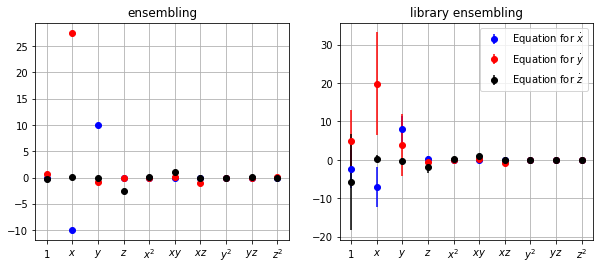

In [31]:
# Default is to sample the entire time series with replacement, generating 10 models on roughly 
# 60% of the total data, with duplicates. 

# Custom feature names
feature_names = ['x', 'y', 'z']

ensemble_optimizer = ps.STLSQ(threshold=1e-3)
model = ps.SINDy(optimizer=ensemble_optimizer, feature_names=feature_names)
model.fit(x_train, t=dt, ensemble=True)
ensemble_coefs = model.coef_list
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

# Now we sub-sample the library. The default is to omit a single library term.
library_ensemble_optimizer = ps.STLSQ(threshold=1e-3)
model = ps.SINDy(optimizer=library_ensemble_optimizer, feature_names=feature_names)
model.fit(x_train, t=dt, library_ensemble=True)
library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

# Plot results
xticknames = model.get_feature_names()
for i in range(10):
    xticknames[i] = '$' + xticknames[i] + '$'
plt.figure(figsize=(10, 4))
colors = ['b', 'r', 'k']
plt.subplot(1, 2, 1)
plt.title('ensembling')
for i in range(3):
    plt.errorbar(range(10), mean_ensemble[i, :], yerr=std_ensemble[i, :], 
                 fmt='o', color=colors[i],
                 label=r'Equation for $\dot{' + feature_names[i] + r'}$')
ax = plt.gca()
plt.grid(True)
ax.set_xticks(range(10))
ax.set_xticklabels(xticknames, verticalalignment='top')
plt.subplot(1, 2, 2)
plt.title('library ensembling')
for i in range(3):
    plt.errorbar(range(10), mean_library_ensemble[i, :], yerr=std_library_ensemble[i, :], 
                 fmt='o', color=colors[i], 
                 label=r'Equation for $\dot{' + feature_names[i] + r'}$')
ax = plt.gca()
plt.grid(True)
plt.legend()
ax.set_xticks(range(10))
ax.set_xticklabels(xticknames, verticalalignment='top');

## Differentiation options

### Pass in pre-computed derivatives
Rather than using one of PySINDy's built-in differentiators, you can compute numerical derivatives using a method of your choice then pass them directly to the `fit` method. This option also enables you to use derivative data obtained directly from experiments.

In [32]:
x_dot_precomputed = ps.FiniteDifference()._differentiate(x_train, t_train)
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_precomputed)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Drop end points from finite difference computation
Many methods of numerical differentiation exhibit poor performance near the endpoints of the data. The `FiniteDifference` and `SmoothedFiniteDifference` methods allow one to easily drop the endpoints for improved accuracy.

In [33]:
fd_drop_endpoints = ps.FiniteDifference(drop_endpoints=True)
    
model = ps.SINDy(differentiation_method=fd_drop_endpoints)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Smoothed finite difference
This method, designed for noisy data, applies a smoother (the default is `scipy.signal.savgol_filter`) before performing differentiation.

In [34]:
smoothed_fd = ps.SmoothedFiniteDifference()
    
model = ps.SINDy(differentiation_method=smoothed_fd)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### More differentiation options
PySINDy is compatible with any of the differentiation methods from the [derivative](https://pypi.org/project/derivative/) package. They are explored in detail in [this notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/5_differentiation.ipynb).

PySINDy defines a `SINDyDerivative` class for interfacing with `derivative` methods. To use a differentiation method provided by `derivative`, simply pass into `SINDyDerivative` the keyword arguments you would give the [dxdt](https://derivative.readthedocs.io/en/latest/api.html#derivative.differentiation.dxdt) method.

In [35]:
spline_derivative = ps.SINDyDerivative(kind="spline", s=1e-2)

model = ps.SINDy(differentiation_method=spline_derivative)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -10.005 x0 + 10.005 x1
(x1)' = 27.832 x0 + -0.970 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


## Feature libraries

### Custom feature names

In [36]:
feature_names = ['x', 'y', 'z']
model = ps.SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

(x)' = -10.004 x + 10.004 y
(y)' = 27.822 x + -0.968 y + -0.994 x z
(z)' = -2.666 z + 0.999 x y


### Custom left-hand side when printing the model

In [37]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print(lhs=['dx0/dt', 'dx1/dt', 'dx2/dt'])

dx0/dt = -10.004 x0 + 10.004 x1
dx1/dt = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
dx2/dt = -2.666 x2 + 0.999 x0 x1


### Customize polynomial library
Omit interaction terms between variables, such as $x_0 x_1$.

In [38]:
poly_library = ps.PolynomialLibrary(include_interaction=False)

model = ps.SINDy(feature_library=poly_library)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = -66.561 1 + -12.909 x0 + 9.193 x1 + 8.429 x2 + 0.256 x0^2 + -0.155 x1^2 + -0.199 x2^2
(x2)' = -48.699 1 + 0.575 x0 + -0.551 x1 + 3.571 x2 + 1.026 x0^2 + 0.250 x1^2 + -0.192 x2^2


### Fourier library

In [39]:
fourier_library = ps.FourierLibrary(n_frequencies=3)

model = ps.SINDy(feature_library=fourier_library)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.231 sin(1 x0) + 0.216 cos(1 x0) + -1.133 sin(1 x1) + 1.277 cos(1 x1) + -1.838 sin(1 x2) + 3.150 cos(1 x2) + -0.197 sin(2 x0) + -0.228 cos(2 x0) + -0.316 cos(2 x1) + -0.470 sin(2 x2) + 0.956 cos(2 x2) + 1.338 sin(3 x1) + -2.305 cos(3 x1) + -0.901 sin(3 x2) + -0.981 cos(3 x2)
(x1)' = -6.609 sin(1 x0) + -10.019 cos(1 x0) + -0.877 sin(1 x1) + 0.139 cos(1 x1) + -4.395 sin(1 x2) + 6.206 cos(1 x2) + -2.976 sin(2 x0) + -3.487 cos(2 x0) + -0.475 sin(2 x1) + -0.766 cos(2 x1) + -0.361 sin(2 x2) + 3.225 cos(2 x2) + -0.660 sin(3 x0) + 2.788 cos(3 x0) + -0.173 sin(3 x1) + 0.139 cos(3 x1) + -2.730 sin(3 x2) + -0.912 cos(3 x2)
(x2)' = 8.105 sin(1 x0) + 8.755 cos(1 x0) + 2.010 sin(1 x1) + -6.823 cos(1 x1) + -0.757 sin(1 x2) + -0.514 cos(1 x2) + 2.552 sin(2 x0) + 2.271 cos(2 x0) + -1.410 sin(2 x1) + -8.332 cos(2 x1) + -0.110 sin(2 x2) + 2.743 sin(3 x0) + -0.119 cos(3 x0) + 3.888 sin(3 x1) + 3.596 cos(3 x1) + -0.283 sin(3 x2) + -0.680 cos(3 x2)


### Fully custom library
The `CustomLibrary` class gives you the option to pass in function names to improve the readability of the printed model. Each function "name" should itself be a function.

In [40]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
library_function_names = [
    lambda x : 'exp(' + x + ')',
    lambda x : '1/' + x,
    lambda x : x,
    lambda x,y : 'sin(' + x + ',' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 58.142 1/x2 + -12.703 x0 + 9.361 x1 + 0.238 x2 + 0.666 sin(x0,x1) + 0.308 sin(x0,x2)
(x2)' = -27.792 1/x2 + -1.368 x0 + 2.936 x1 + -0.204 x2 + 5.722 sin(x0,x1) + -4.872 sin(x0,x2) + -1.343 sin(x1,x2)


### Fully custom library, default function names
If no function names are given, default ones are given: `f0`, `f1`, ...

In [41]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

(x0)' = -10.004 f2(x0) + 10.004 f2(x1)
(x1)' = 58.142 f1(x2) + -12.703 f2(x0) + 9.361 f2(x1) + 0.238 f2(x2) + 0.666 f3(x0,x1) + 0.308 f3(x0,x2)
(x2)' = -27.792 f1(x2) + -1.368 f2(x0) + 2.936 f2(x1) + -0.204 f2(x2) + 5.722 f3(x0,x1) + -4.872 f3(x0,x2) + -1.343 f3(x1,x2)


### Identity library
The `IdentityLibrary` leaves input data untouched. It allows the flexibility for users to apply custom transformations to the input data before feeding it into a `SINDy` model.

In [42]:
identity_library = ps.IdentityLibrary()

model = ps.SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = -12.788 x0 + 9.418 x1 + 0.336 x2
(x2)' = -1.260 x0 + 2.849 x1 + -0.258 x2


### Concatenate two libraries
Two or more libraries can be combined via the `+` operator.

In [43]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library

model = ps.SINDy(feature_library=combined_library)
model.fit(x_train, t=dt)
model.print()
model.get_feature_names()

(x0)' = -10.004 x0 + 10.004 x1
(x1)' = -12.684 x0 + 9.393 x1 + 0.321 x2 + -4.676 sin(1 x0) + -6.833 cos(1 x0) + 1.860 sin(1 x1) + -1.880 cos(1 x1) + -2.428 sin(1 x2) + 3.058 cos(1 x2)
(x2)' = -1.416 x0 + 2.888 x1 + -0.245 x2 + 7.542 sin(1 x0) + 6.775 cos(1 x0) + 2.082 sin(1 x1) + -6.427 cos(1 x1) + -0.400 sin(1 x2) + -1.659 cos(1 x2)


['x0',
 'x1',
 'x2',
 'sin(1 x0)',
 'cos(1 x0)',
 'sin(1 x1)',
 'cos(1 x1)',
 'sin(1 x2)',
 'cos(1 x2)']

### Tensor two libraries together
Two or more libraries can be tensored together via the `*` operator.

In [44]:
identity_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
combined_library = identity_library * fourier_library

model = ps.SINDy(feature_library=combined_library)
model.fit(x_train, t=dt)
model.print()
print("Feature names:\n", model.get_feature_names())

(x0)' = 0.181 x0sin(1 x0) + 1.186 x0sin(1 x1) + -14.413 x0cos(1 x1) + 0.590 x0sin(1 x2) + -0.134 x0cos(1 x2) + -0.216 x1sin(1 x0) + -0.776 x1sin(1 x1) + 8.669 x1cos(1 x1) + -0.472 x1sin(1 x2) + 1.923 x2sin(1 x1) + 0.301 x2cos(1 x1) + 0.137 x2cos(1 x2) + 1.098 x0^2sin(1 x1) + -0.107 x0^2cos(1 x1) + -0.132 x0 x1cos(1 x0) + -1.144 x0 x1sin(1 x1) + 0.105 x0 x1cos(1 x1) + 0.408 x0 x2cos(1 x1) + 0.112 x1^2cos(1 x0) + 0.349 x1^2sin(1 x1) + -0.271 x1 x2cos(1 x1) + -0.117 x2^2sin(1 x1)
(x1)' = 12.149 x0sin(1 x0) + -0.740 x0cos(1 x0) + 0.176 x0cos(1 x1) + -7.387 x0sin(1 x2) + -1.686 x1sin(1 x0) + -3.936 x1cos(1 x0) + -0.182 x1sin(1 x1) + -0.101 x1cos(1 x1) + 3.246 x1sin(1 x2) + -0.207 x1cos(1 x2) + -0.215 x2sin(1 x0) + -0.345 x2cos(1 x0) + 0.346 x2cos(1 x2) + 0.303 x0^2sin(1 x0) + -0.295 x0^2sin(1 x2) + -0.920 x0 x1sin(1 x0) + -0.529 x0 x1cos(1 x0) + 0.203 x0 x1sin(1 x2) + -0.295 x0 x2sin(1 x0) + 0.283 x0 x2sin(1 x2) + 0.465 x1^2sin(1 x0) + 0.341 x1^2cos(1 x0) + -0.111 x1 x2sin(1 x0) + 0.219 x1 

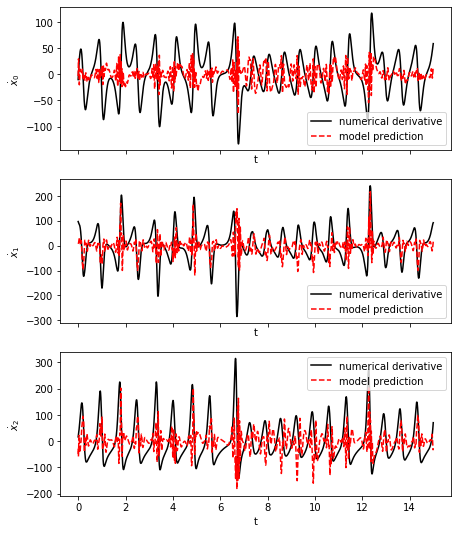

In [45]:
# Predict derivatives using the learned model
# the model is quite bad of course because the library has useless terms
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Generalized library

Create the most general and flexible possible library by combining and tensoring as many libraries as you want, and you can even specify which input variables to use to generate each library! A much more advanced example is shown further below for PDEs.
One can specify:
<br>
1. N different libraries to add together
2. A list of inputs to use for each library. For two libraries with four inputs this would look like inputs_per_library = [[0, 1, 2, 3], [0, 1, 2, 3]] and to avoid using the first two input variables in the second library, you would change it to something like inputs_per_library = [[0, 1, 2, 3], [2, 2, 2, 3]], since duplicates are thrown out and [2, 2, 2, 3] will reduce to [2, 3]. 
        
3. A list of libraries to tensor together and add to the overall library. For four libraries, we could make three tensor libraries by using tensor_array = [[1, 0, 1, 1], [1, 1, 1, 1], [0, 0, 1, 1]]. The first sub-array takes the tensor product of libraries 0, 2, 3, the second takes the tensor product of all of them, and the last takes the tensor product of the libraries 2 and 3. This is a silly example since the [1, 1, 1, 1] tensor product already contains all the possible terms. <br>
<br>
Note that using this is a more advanced feature, but with the benefit that it allows any SINDy library you want. <br>

In [46]:
# Initialize two libraries
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()

# Initialize the default inputs, i.e. each library
# uses all the input variables
inputs_temp = np.tile([0, 1, 2], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 3))
print(inputs_per_library)

# Don't use the x0 input for generating the Fourier library
inputs_per_library[1, 0] = 1

# Tensor all the polynomial and Fourier library terms together
tensor_array = [[1, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary([poly_library, fourier_library], 
                                            tensor_array=tensor_array,
                                            inputs_per_library=inputs_per_library)

# Fit the model and print the library feature names to check success
model = ps.SINDy(feature_library=generalized_library)
model.fit(x_train, t=dt)
model.print()
print("Feature names:\n", model.get_feature_names())

[[0 1 2]
 [0 1 2]]
(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.822 x0 + -0.968 x1 + -0.994 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1
Feature names:
 ['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'x0sin(1 x1)', 'x0cos(1 x1)', 'x0sin(1 x2)', 'x0cos(1 x2)', 'x1sin(1 x1)', 'x1cos(1 x1)', 'x1sin(1 x2)', 'x1cos(1 x2)', 'x2sin(1 x1)', 'x2cos(1 x1)', 'x2sin(1 x2)', 'x2cos(1 x2)', 'x0^2sin(1 x1)', 'x0^2cos(1 x1)', 'x0^2sin(1 x2)', 'x0^2cos(1 x2)', 'x0 x1sin(1 x1)', 'x0 x1cos(1 x1)', 'x0 x1sin(1 x2)', 'x0 x1cos(1 x2)', 'x0 x2sin(1 x1)', 'x0 x2cos(1 x1)', 'x0 x2sin(1 x2)', 'x0 x2cos(1 x2)', 'x1^2sin(1 x1)', 'x1^2cos(1 x1)', 'x1^2sin(1 x2)', 'x1^2cos(1 x2)', 'x1 x2sin(1 x1)', 'x1 x2cos(1 x1)', 'x1 x2sin(1 x2)', 'x1 x2cos(1 x2)', 'x2^2sin(1 x1)', 'x2^2cos(1 x1)', 'x2^2sin(1 x2)', 'x2^2cos(1 x2)']


## SINDy with control (SINDYc)
SINDy models with control inputs can also be learned. Here we learn a Lorenz control model:
$$ \dot{x} = \sigma (y - x) + u_0$$
$$ \dot{y} = x(\rho - z) - y $$
$$ \dot{z} = x y - \beta z - u_1$$

### Train the model

In [47]:
# Control input
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])

# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz_control, t_train_span, x0_train, t_eval=t_train, args=(u_fun,)).y.T
u_train = u_fun(t_train)

In [48]:
# Instantiate and fit the SINDYc model
model = ps.SINDy()
model.fit(x_train, u=u_train, t=dt)
model.print()

(x0)' = -10.003 x0 + 10.003 x1 + 0.998 u0
(x1)' = 27.789 x0 + -0.954 x1 + -0.993 x0 x2
(x2)' = -2.669 x2 + -0.998 u1 + 0.999 x0 x1


### Assess results on a test trajectory

In [49]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
u_test = u_fun(t_test)
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz_control, t_test_span, x0_test, t_eval=t_test, args=(u_fun,)).y.T
u_test = u_fun(t_test)

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, u=u_test, t=dt))

Model score: 0.999920


### Predict derivatives with learned model

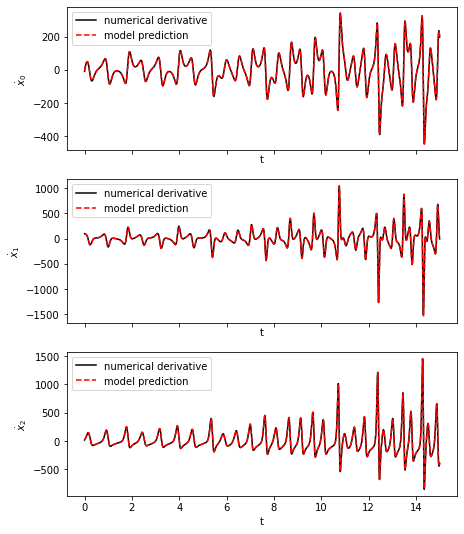

In [50]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time (control input function known)
When working with control inputs `SINDy.simulate` requires a *function* to be passed in for the control inputs, `u`, because the default integrator used in `SINDy.simulate` uses adaptive time-stepping. We show what to do in the case when you do not know the functional form for the control inputs in the example following this one.

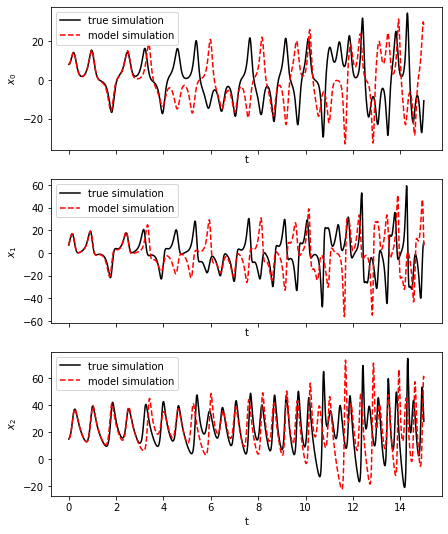

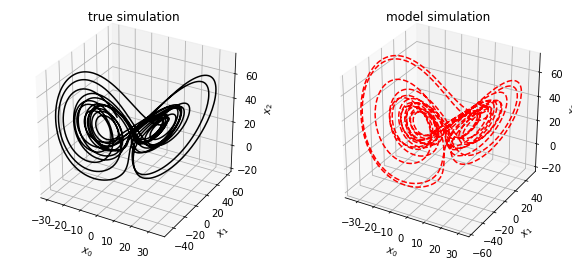

In [51]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test, u=u_fun)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

### Simulate forward in time (unknown control input function)
If you only have a vector of control input values at the times in `t_test` and do not know the functional form for `u`, the `simulate` function will internally form an interpolating function based on the vector of control inputs. As a consequence of this interpolation procedure, `simulate` will not give a state estimate for the last time point in `t_test`. This is because the default integrator, `scipy.integrate.solve_ivp` (with LSODA as the default solver), is adaptive and sometimes attempts to evaluate the interpolant outside the domain of interpolation, causing an error.

In [52]:
u_test = u_fun(t_test)

Length of t_test: 7500
Length of simulation: 7499


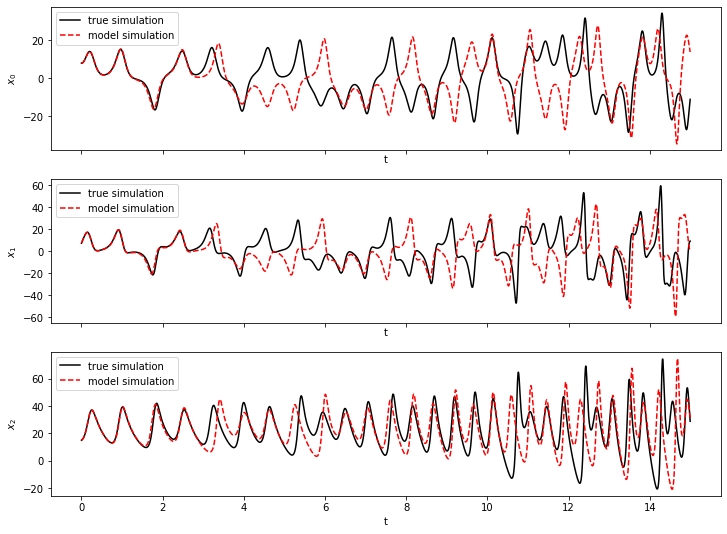

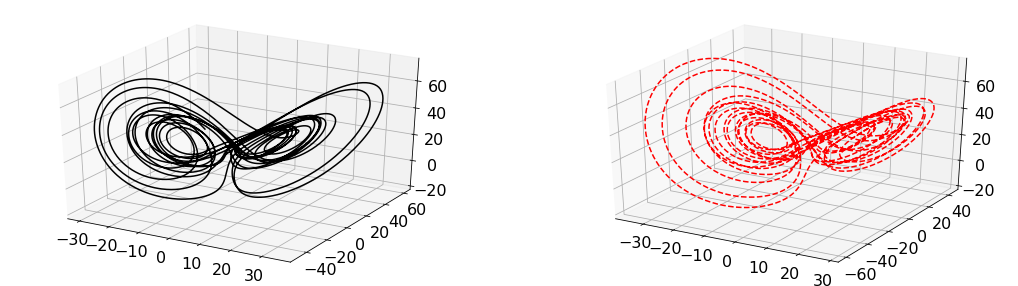

In [53]:
x_test_sim = model.simulate(x0_test, t_test, u=u_test)

# Note that the output is one example short of the length of t_test
print('Length of t_test:',len(t_test))
print('Length of simulation:',len(x_test_sim))

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(12, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test[:-1], x_test[:-1, i], 'k', label='true simulation')
    axs[i].plot(t_test[:-1], x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.zaxis.set_tick_params(labelsize=16)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax2.zaxis.set_tick_params(labelsize=16)

fig.show()
plt.savefig('lorenz_control.pdf')

## Implicit ODEs 
How would we use SINDy to solve an implicit ODE? In other words, now the LHS can depend on x and x_dot, 
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}})$$


In order to deal with this, we need a library $\Theta(\mathbf{x}, \dot{\mathbf{x}})$. SINDy parallel implicit (SINDy-PI) is geared to solve these problems. It solves the optimization problem,
$$argmin_\mathbf{\Xi} (\|\Theta(\mathbf{X}, \dot{\mathbf{X}}) - \Theta(\mathbf{X}, \dot{\mathbf{X}})\mathbf{\Xi}\| + \lambda \|\mathbf{\Xi}\|_1)$$
such that diag$(\mathbf{\Xi}) = 0$. So for every candidate library term it generates a different model. With N state variables, we need to choose N of the equations to solve for the system evolution. See the [SINDy-PI notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/9_sindypi_with_sympy.ipynb) for more details. 

Here we illustrate successful identification of the 1D Michelson-Menten enzyme model
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Or, equivalently
$$\dot{x} = 0.6 - 3 x - \frac{10}{3} x\dot{x}.$$

Note that some of the model fits fail. This is usually because the LHS term being fitted is a poor match to the data, but this error can also be caused by CVXPY not liking the parameters passed to the solver.


In [54]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t).y.T

# Initialize custom SINDy library so that we can have x_dot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [
    lambda x: 1,
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: 1, lambda x: x]

# library function names includes both the x_library_functions and x_dot_library_functions names
library_function_names = [
    lambda x: "",
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: "",
    lambda x: x,
]

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t[1:-1],
    function_names=library_function_names,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
# Note that if LHS of the equation fits the data poorly,
# CVXPY often returns failure.
sindy_opt = ps.SINDyPI(threshold=1e-7, tol=1e-10, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

Solver failed on model  0 , setting coefs to zeros
Solver failed on model  1 , setting coefs to zeros
Solver failed on model  2 , setting coefs to zeros
Solver failed on model  3 , setting coefs to zeros
Solver failed on model  5 , setting coefs to zeros
Solver failed on model  6 , setting coefs to zeros
Solver failed on model  7 , setting coefs to zeros
Solver failed on model  8 , setting coefs to zeros
Solver failed on model  9 , setting coefs to zeros
Solver failed on model  10 , setting coefs to zeros
Solver failed on model  12 , setting coefs to zeros
 = 0.000
x0 = 0.000
x0x0 = 0.000
x0x0x0 = 0.000
x0x0x0x0 = 1.000 x0x0x0x0x0_dot
x0_dot = 0.000
 = 0.000
x0_dot = 0.000
x0x0_dot = 0.000
x0x0x0_dot = 0.000
x0x0x0x0_dot = 0.000
x0x0x0x0x0_dot = 1.000 x0x0x0x0
 = 0.000
x0 = -0.003  + 0.214 x0 + -1.163 x0x0 + 1.011 x0x0x0 + -0.003 x0_dot + 0.028  + -0.003 x0_dot + 0.214 x0x0_dot + -1.163 x0x0x0_dot + 1.011 x0x0x0x0_dot + 0.028  + 1.251 x0x0x0x0
x0x0 = -0.015  + 0.188 x0 + -0.382 x0x0 + 

# PDEFIND Feature Overview
PySINDy now supports SINDy for PDE identification (PDE-FIND) (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614.). We illustrate a basic example on Burgers' equation:
$$u_t = -uu_x + 0.1u_{xx}$$

Note that for noisy PDE data, the most robust method is to use the weak form of PDEFIND (see below)!

(x0)' = 0.100 x0_11 + -1.001 x0x0_1


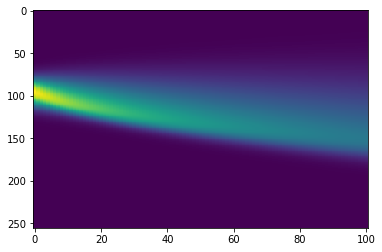

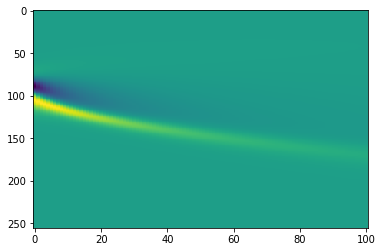

In [55]:
from scipy.io import loadmat

# Load data
data = loadmat("data/burgers.mat")
t = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot the spatiotemporal data
plt.figure()
plt.imshow(u, aspect="auto")
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
u_dot = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(u_dot[:, :, 0], aspect="auto")

u_flattened = np.reshape(u, (len(x) * len(t), 1))
u_dot_flattened = np.reshape(u_dot, (len(x) * len(t), 1))

# Define quadratic library with up to third order derivatives on a uniform spatial grid
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Note that u and u_dot are flattened, and u_dot must be passed to model.fit
model.fit(u_flattened, x_dot=u_dot_flattened)
model.print()

### Weak form
PySINDy also supports weak form PDE identification following Reinbold et al. (2019)

In [56]:
# Convert PDE data into weak form data

from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference

# Same library but set weak_form=True and need to pass the temporal grid
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    temporal_grid=t,
    is_uniform=True,
    weak_form=True,
)

# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_1D(u, t, pde_lib):  # For weak form 1D PDES
    K = pde_lib.K
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, u.shape[-1]))
    # Define interpolation object to interpolate u(x, time) onto the grid
    # spanned by X, t
    for j in range(u.shape[-1]):
        u_interp = RectBivariateSpline(x, t, u[:, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :])
            # Interpolate u onto the kth subdomain
            u_new = u_interp.ev(X, tgrid)
            u_new = np.reshape(u_new, (num_pts_per_domain, num_pts_per_domain, 1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                pde_lib.tgrid_k[k, :],
                k,
                0,
                0,
                0,
                1,
            )
            # Integrate over x, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(u_new * w_diff, x=pde_lib.xgrid_k[k, :], axis=0),
                    x=pde_lib.tgrid_k[k, :],
                    axis=0,
                )
            )
    return u_dot_integral


u_shaped = np.reshape(u, (len(x), len(t), 1))
u_dot_integral = convert_u_dot_1D(u_shaped, t, pde_lib)

In [57]:
optimizer = ps.STLSQ(threshold=0.01, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Note that u and u_dot are flattened, and u_dot_integral must be passed to model.fit
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

(x0)' = 0.100 x0_11 + -1.002 x0x0_1


### GeneralizedLibrary
The `GeneralizedLibrary` is meant for identifying ODEs/PDEs the depend on the spatial and/or temporal coordinates and/or nonlinear functions of derivative terms.

Often, especially for PDEs, there is some explicit spatiotemporal dependence such as through an external potential. For instance, a well known PDE is the Poisson equation for the electric potential in 2D:
$$ (\partial_{xx} + \partial_{yy})\phi(x, y) = \rho(x,y).$$


**Note that all other SINDy libraries implemented in PySINDy only allow for functions of $\phi(x, y)$ on the RHS of the SINDy equation.** This method allows for functions of the spatial and temporal coordinates like $\rho(x, y)$, as well as anything else you can imagine.

Let's suppose we have a distribution like the following
$$ \rho(x, y) = x^2 + y^2$$
We can actually directly input $(\partial_{xx} + \partial_{yy})\phi(x, y)$ as "x_dot" in the SINDy fit, functionally replacing the normal left-hand-side (LHS) of the SINDy equation. Then we can build a candidate library of terms to discover the correct charge density matching this data.

In the following, we will build three different libraries, each using their own subset of inputs, tensor a subset of them together, and fit a model. This is total overkill for this problem but hopefully is illustrative.

(x0)' = 1.045 x1^2 + 1.061 x2^2
(x1)' = 1.238 x1^2
(x2)' = 1.244 x2^2


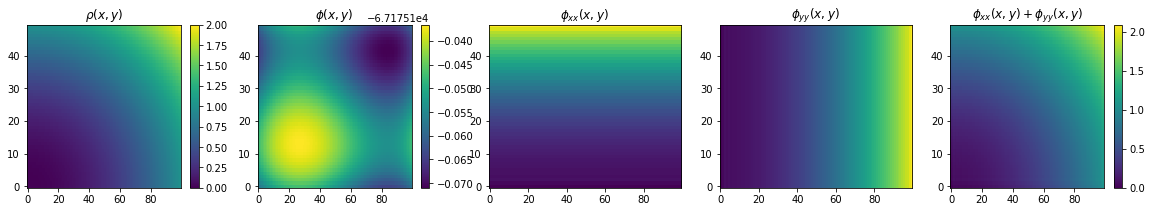

In [58]:
# Define the spatial grid
nx = 50
Lx = 1
ny = 100
Ly = 1
x = np.linspace(0, Lx, nx)
dx = x[1] - x[0]
y = np.linspace(0, Ly, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing="ij")

# Define rho
rho = X ** 2 + Y ** 2
plt.figure(figsize=(20, 3))
plt.subplot(1, 5, 1)
plt.imshow(rho, aspect="auto", origin="lower")
plt.title(r"$\rho(x, y)$")
plt.colorbar()

# Generate the PDE data for phi by fourier transforms since this is homogenous PDE
# and we assume periodic boundary conditions
nx2 = int(nx / 2)
ny2 = int(ny / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / Lx) * np.hstack(
    (np.linspace(0, nx2 - 1, nx2), np.linspace(-nx2, -1, nx2))
)
ky = (2 * np.pi / Ly) * np.hstack(
    (np.linspace(0, ny2 - 1, ny2), np.linspace(-ny2, -1, ny2))
)

# Get 2D mesh in (kx, ky)
KX, KY = np.meshgrid(kx, ky, indexing="ij")
K2 = KX ** 2 + KY ** 2
K2[0, 0] = 1e-5

# Generate phi data by solving the PDE and plot results
phi = np.real(np.fft.ifft2(-np.fft.fft2(rho) / K2))
plt.subplot(1, 5, 2)
plt.imshow(phi, aspect="auto", origin="lower")
plt.title(r"$\phi(x, y)$")
plt.colorbar()

# Make del^2 phi and plot various quantities
phi_shaped = np.reshape(phi, (len(x), len(y), 1))
phi_xx = np.zeros((len(x), len(y), 1))
phi_yy = np.zeros((len(x), len(y), 1))
for i in range(len(y)):
    phi_xx[:, i, :] = ps.FiniteDifference(d=2)._differentiate(phi_shaped[:, i, :], t=dx)
for i in range(len(x)):
    phi_yy[i, :, :] = ps.FiniteDifference(d=2)._differentiate(phi_shaped[i, :, :], t=dy)
plt.subplot(1, 5, 3)
plt.imshow(phi_xx[:, :, 0], aspect="auto", origin="lower")
plt.title(r"$\phi_{xx}(x, y)$")
plt.subplot(1, 5, 4)
plt.imshow(phi_yy[:, :, 0], aspect="auto", origin="lower")
plt.title(r"$\phi_{yy}(x, y)$")
plt.subplot(1, 5, 5)
plt.imshow(
    phi_xx[:, :, 0] + phi_yy[:, :, 0] + abs(np.min(phi_xx[:, :, 0] + phi_yy[:, :, 0])),
    aspect="auto",
    origin="lower",
)
plt.title(r"$\phi_{xx}(x, y) + \phi_{yy}(x, y)$")
plt.colorbar()

# Define a PolynomialLibrary, FourierLibrary, and PDELibrary
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
X_mesh, Y_mesh = np.meshgrid(x, y)
pde_library = ps.PDELibrary(
    derivative_order=1, spatial_grid=np.asarray([X_mesh, Y_mesh]).T
)

# Inputs are going to be all the variables [phi, X, Y].
# Remember we can use a subset of these input variables to generate each library
phi_flattened = np.reshape(phi, (len(x) * len(y), 1))
X_flattened = np.reshape(X, (len(x) * len(y), 1))
Y_flattened = np.reshape(Y, (len(x) * len(y), 1))
data = np.squeeze(np.asarray([phi_flattened, X_flattened, Y_flattened])).T

# The 'x_dot' terms will be [phi_xx, X, Y]
# Remember these are the things that are being fit in the SINDy regression
Laplacian_phi = np.reshape(
    phi_xx[:, :, 0] + phi_yy[:, :, 0] + abs(np.min(phi_xx[:, :, 0] + phi_yy[:, :, 0])),
    (len(x) * len(y), 1),
)
data_dot = np.squeeze(np.asarray([Laplacian_phi, X_flattened, Y_flattened])).T

# Tensor polynomial library with the PDE library
tensor_array = [[1, 0, 1]]

# Remove X and Y from PDE library terms because why would we take these derivatives
inputs_temp = np.tile([0, 1, 2], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 3))
inputs_per_library[2, 1] = 0
inputs_per_library[2, 2] = 0

# Fit a generalized library of 3 feature libraries + 1 internally generated tensored library
# and only use the input variable phi for the PDELibrary. Note that this holds true both
# for the individual PDELibrary and any tensored libraries constructed from it.
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)
optimizer = ps.STLSQ(threshold=8, normalize_columns=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(data, x_dot=data_dot)
# Note scale of phi is large so some coefficients >> 1
# --> would want to rescale phi with eps_0 for a harder problem
model.print()

Feature names:
 ['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'f0(x0)', 'x0_1', 'x0f0(x0)', 'x0x0_1', 'x1f0(x0)', 'x1x0_1', 'x2f0(x0)', 'x2x0_1', 'x0^2f0(x0)', 'x0^2x0_1', 'x0 x1f0(x0)', 'x0 x1x0_1', 'x0 x2f0(x0)', 'x0 x2x0_1', 'x1^2f0(x0)', 'x1^2x0_1', 'x1 x2f0(x0)', 'x1 x2x0_1', 'x2^2f0(x0)', 'x2^2x0_1']


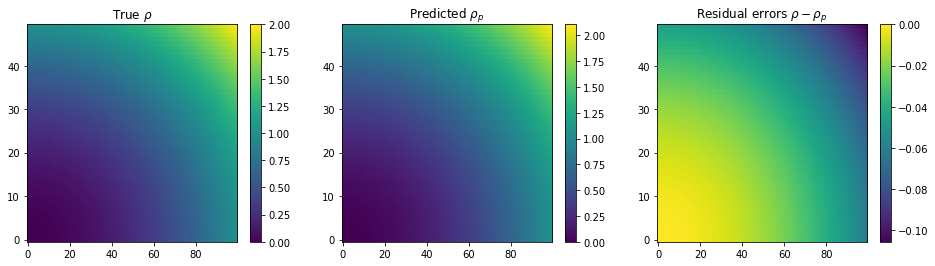

In [59]:
# Get prediction of rho and plot results
rho_pred = np.reshape(model.predict(data), (len(x), len(y), 3))
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title(r'True $\rho$')
plt.imshow(rho, aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title(r'Predicted $\rho_p$')
plt.imshow(rho_pred[:, :, 0], aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title(r'Residual errors $\rho - \rho_p$')
plt.imshow(rho - rho_pred[:, :, 0], aspect='auto', origin='lower')
plt.colorbar()
print("Feature names:\n", model.get_feature_names())